In [1]:
import os
import json
from pathlib import Path
import shutil
import random
import numpy as np

from datasets import load_dataset
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Build Inference Dataset

In [2]:
from pdf2image import convert_from_path
import glob

test_file_name = "test_1"
# Adding a page cut-off index to avoid processing large PDFs
cut_off_index = 5

# Set the PDF file path
inference_path = f'/home/harish3110/document-ai/data/inference/{test_file_name}/'
pdf_file_path = glob.glob(inference_path + '*.pdf')[0]
img_path = f"{inference_path}images"
os.makedirs(img_path, exist_ok=True)

# Convert PDF to a list of Pillow Image objects
images = convert_from_path(pdf_file_path)
# Save each image as a PNG file
for i, image in enumerate(images[:cut_off_index]):
    image.save(f'{img_path}/page_{i+1}.jpeg', 'JPEG')

In [3]:
# Load dataset
path = Path(img_path)
inference_dataset = load_dataset("imagefolder", data_dir=path, split="train")

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/harish3110/.cache/huggingface/datasets/imagefolder/default-cce55ea13e52a110/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [4]:
print(f"Dataset has {len(inference_dataset)} images")

Dataset has 8 images


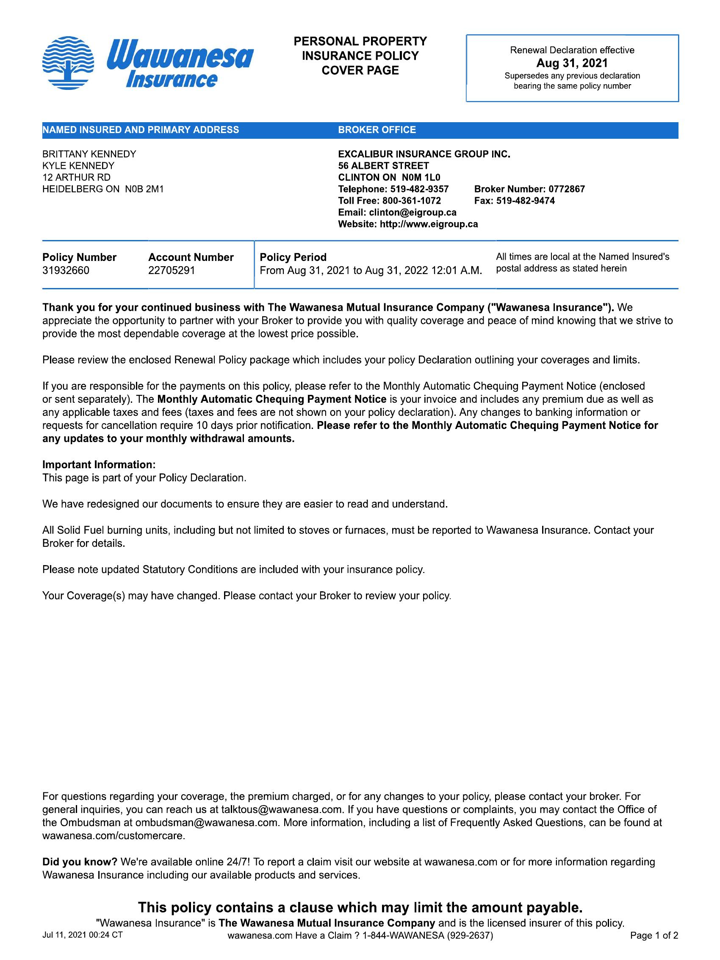

In [5]:
index = 0
image = inference_dataset[index]["image"].resize((720,960))
image

### Load Model and Processor

In [6]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

model_name = "harish3110/donut-quandri-all"

processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

### Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [7]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


### Generate

Finally, we let the model autoregressively generate the structured data.

In [8]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [9]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_effective_document_date> Aug 31, 2021</s_effective_document_date><s_effective_date> Aug 31, 2021</s_effective_date><s_expiry_date> Aug 31, 2022</s_expiry_date>


### Convert to JSON

We can convert the generated sequence to JSON if required:

In [10]:
processor.token2json(sequence)

{'effective_document_date': 'Aug 31, 2021',
 'effective_date': 'Aug 31, 2021',
 'expiry_date': 'Aug 31, 2022'}

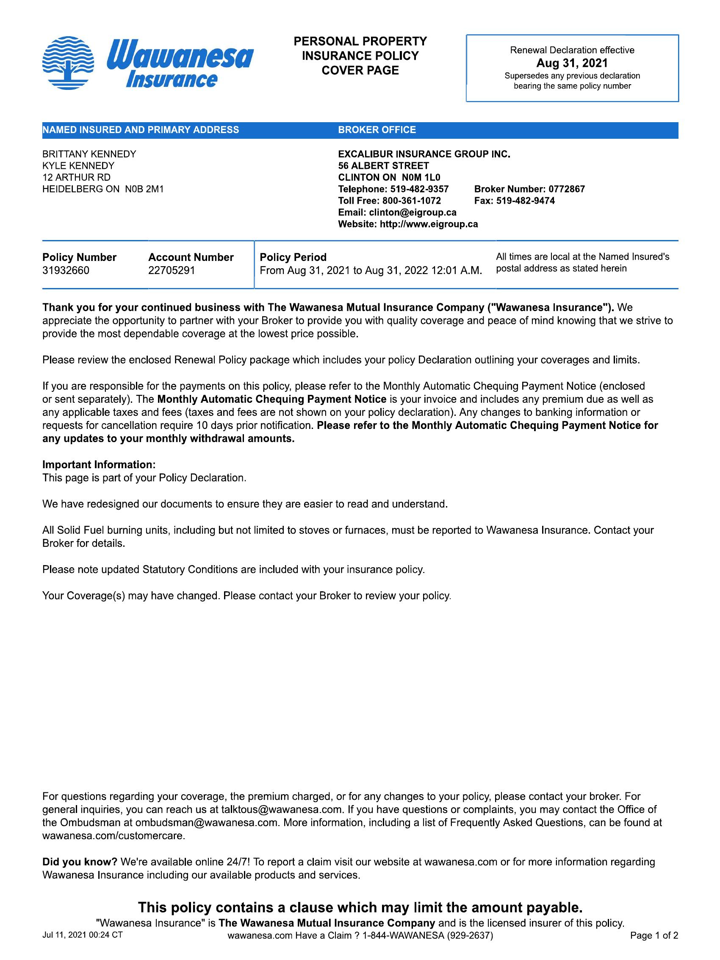

In [11]:
image

In [12]:
import torch
import re
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def process_document(image):
    # prepare encoder inputs
    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
          
    # generate answer
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
    
    # postprocess
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    
    return processor.token2json(sequence)

In [13]:
results = []
for index in range(len(inference_dataset)):
    image = inference_dataset[index]["image"]
    data = process_document(image)
    data = {key:value for key, value in data.items() if key != "text_sequence"}
    data['page_number'] = index + 1
    results.append(data)

results

[{'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 1},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 2},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'premium': '$ 2,107.00',
  'page_number': 3},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 4},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 5},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 6},
 {'effective_document_date': 'Aug 31, 2021',
  'effective_date': 'Aug 31, 2021',
  'expiry_date': 'Aug 31, 2022',
  'page_number': 7},
 {'effective_document_date':

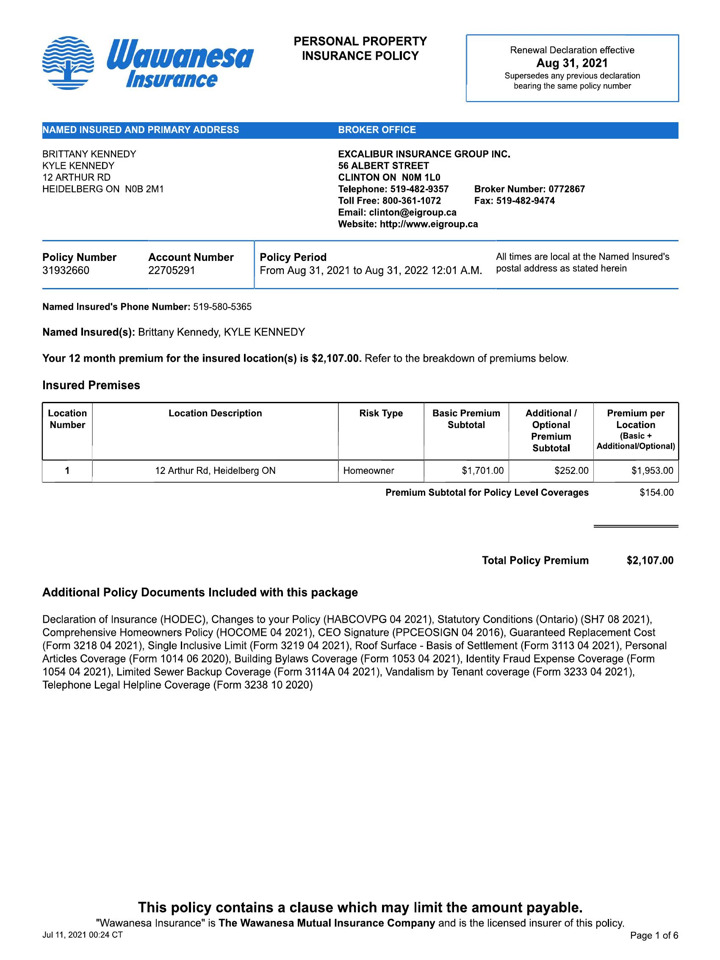

In [64]:
inference_dataset['image'][2].resize((720,960))